In [1]:
import heron
import heron.regression as hgp

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import signal

In [3]:
gp = hgp.load("/home/daniel/repositories/heron/scripts/paper_models/models/undiscovered snafu.gp")

In [4]:
gp.training_data

array([[ 0.64607679,  0.        ,  0.71381555, ...,  0.36937852,
         0.        ,  1.        ],
       [ 0.64774624,  0.        ,  0.71381555, ...,  0.36937852,
         0.        ,  1.        ],
       [ 0.64941569,  0.        ,  0.71381555, ...,  0.36937852,
         0.        ,  1.        ],
       ..., 
       [ 0.9966611 ,  0.        ,  0.14144666, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.99833055,  0.        ,  0.14144666, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.        ,  0.        ,  0.14144666, ...,  0.        ,
         0.        ,  1.        ]])

/home/daniel/.virtualenvs/IGRlaptop21/heron/lib/python2.7/site-packages/matplotlib-2.0.0-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u"'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


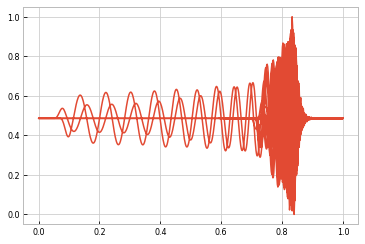

In [5]:
plt.plot(gp.training_data[:,0], gp.training_y)

In [32]:
noise = np.random.randn(200)*0.4
noisy_data = gp.training_y[200:400]+noise
noisy_time = gp.training_data[200:400,0]

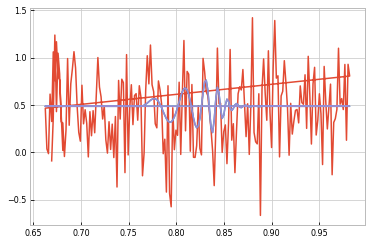

In [33]:
plt.plot(noisy_time ,noisy_data)

template = noisy_data = gp.training_y[200:400]
template_time = gp.training_data[200:400,0]
plt.plot(noisy_time ,noisy_data)
plt.plot(template_time, template)

In [34]:
from matplotlib.mlab import psd

In [35]:
def inner_product_noise(x, y, noise, psd=None,  srate=16834):
    """
    Calculate the noise-weighted inner product of two random functions
    """
    nfft = 4*srate
    window = signal.get_window(('tukey', 0.1), len(x))
    fwindow = signal.get_window(('tukey', 0.1), nfft)

    xdata = x*window
    ydata = y*window
    noisefft = np.fft.rfft(noise, nfft)*np.fft.rfft(noise, nfft).conj()
    xy = np.fft.rfft(xdata, nfft)*np.fft.rfft(ydata, nfft).conj()
    if not psd:
        psd, pfreqs = psd(wdata, NFFT=nfft, Fs=srate, window=fwindow, noverlap=0)
    psd = psd + noisefft
    return 4*np.real(np.sum(xy/(psd)))

In [41]:
def matched_likelihood(data, template, templatesigma = 0, psd=None, srate=16834):
    """
    Calculate the simple match of some data, given a template, and return its
    log-likelihood.
    
    Parameters
    ----------
    data : `np.ndarray`
        An array of data which is believed to contain a signal.
    template : `np.ndarray`
        An array containing a template to match to the data.
    template_sigma : `np.ndarray`
        An array of the uncertainty of the template
    """
    return -np.log(np.dot(templatesigma, templatesigma)) - 0.5* inner_product_noise(data-template, data-template, templatesigma, srate) 

In [42]:
from heron.sampling import draw_samples

In [46]:
gp.training_data[201]

array([ 0.67111853,  0.        ,  0.14151821,  0.        ,  0.5       ,
        1.        ,  0.        ,  0.29292677])

In [44]:
likes = []
for a in np.linspace(-0.5,0.5, 100):
    point = [ 0.64607679,  a,  0.71381555,  0., 0.5, 0.36937852,  0. ,  1. ]
    cross = dict(zip(gp.training_object.target_names, point))
    cross['t'] = [noisy_time[0],noisy_time[-1],len(noisy_time)]
    locs = draw_samples(gp, **cross)
    pred = gp.prediction(locs, normalised=True)

    #plt.plot(locs[:,0], pred[0]+0.5)
    #uncer = pred[1]/pred[1].max()
    #plt.fill_between(locs[:,0], pred[0]+uncer**2+0.5, pred[0]-uncer**2+0.5, alpha=0.2)
    #plt.ylim([-.5,1.5])
    #plt.plot(template_time, template)
    likes.append(matched_likelihood(noisy_data, pred[0]+0.5, pred[1], psd=psd, srate = 100))

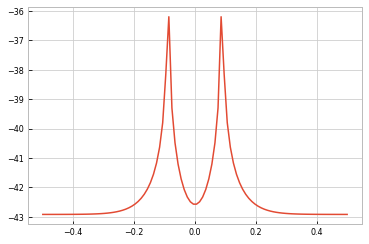

In [45]:
plt.plot(np.linspace(-0.5,0.5,100), likes)

In [48]:
aval = np.linspace(-0.5,0.5,100)

In [53]:
aval[np.argmax(likes)]

0.085858585858585856

In [56]:
gp.training_data[201]

array([ 0.67111853,  0.        ,  0.14151821,  0.        ,  0.5       ,
        1.        ,  0.        ,  0.29292677])

In [97]:
gp.training_object.target_names

['t',
 '$q$',
 '$a_{1x}$',
 '$a_{1y}$',
 '$a_{1z}$',
 '$a_{2x}$',
 '$a_{2y}$',
 '$a_{2z}$']

In [61]:
likes = []
for a in np.linspace(-1,1, 100):
    point = [ 0.67111853,  0.        ,  a,  0.        ,  0.5       ,
        1.        ,  0.        ,  0.29292677]
    cross = dict(zip(gp.training_object.target_names, point))
    cross['t'] = [noisy_time[0],noisy_time[-1],len(noisy_time)]
    locs = draw_samples(gp, **cross)
    pred = gp.prediction(locs, normalised=True)

    #plt.plot(locs[:,0], pred[0]+0.5)
    #uncer = pred[1]/pred[1].max()
    #plt.fill_between(locs[:,0], pred[0]+uncer**2+0.5, pred[0]-uncer**2+0.5, alpha=0.2)
    #plt.ylim([-.5,1.5])
    #plt.plot(template_time, template)
    likes.append(matched_likelihood(noisy_data, pred[0]+0.5, pred[1], psd=psd, srate = 100))

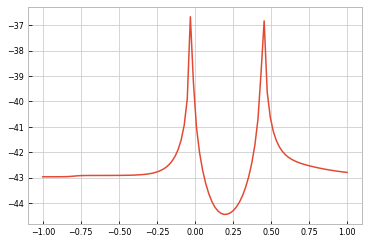

In [62]:
plt.plot(np.linspace(-1,1,100), likes)

In [64]:
np.linspace(-1,1, 100)[np.argmin(likes)]

0.19191919191919204